In [77]:
import pandas as pd
import wmfdata as wmf
from wmfdata.utils import pd_display_all
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [ ]:
wmf.charting.set_mpl_style()

# Summary
There was a significant drop in KaiOS web pageviews during November 2019, with the daily average dropping from ~700 k to ~350 k over the course of several weeks. The decline has continued more gradually up until the present. Why did this happen? ([T242853](https://phabricator.wikimedia.org/T242853))

This drop seems to be very specific to KaiOS, rather than a broader trend within India (the overwhelming majority of KaiOS users are in India). Within KaiOS, the drop is consistent across Indian states. However, within KaiOS pageviews search-engine referred pageviews dropped significantly more than pageviews from other referrer types (in Indian mobile pageviews generally, pageviews of each referrer type were stable). Although internally-referred pageviews dropped too, the ratio of internal to external pageviews actually rose, suggesting that the decline in internally-referred pageviews is just an effect of the drop in search-engine referred pageviews. 

All this suggests that something specific to KaiOS changed in mid-November that decreased how often KaiOS users visited Wikipedia through search engine results. Mostly likely, this was a software change that decreased how often those users searched the web. Less likely explanations are a decrease in the number of KaiOS users or the amount of phone usage by each of those users (such behavior changes probably would not have happened so sharply) and a decrease in Wikipedia's positioning in Google results or a decrease in clickthrough on those results (overall search engine referrals in India probably would have decreased too).

# Trends in Indian mobile views

In [15]:
views = wmf.spark.run("""
SELECT
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.projectview_hourly
WHERE
  country_code = "IN" AND
  access_method = "mobile web" AND
  agent_type != "spider" AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [ ]:
views = (
  views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-03'") # Remove partial day
  .sort_values("date")
  .set_index("date")
)

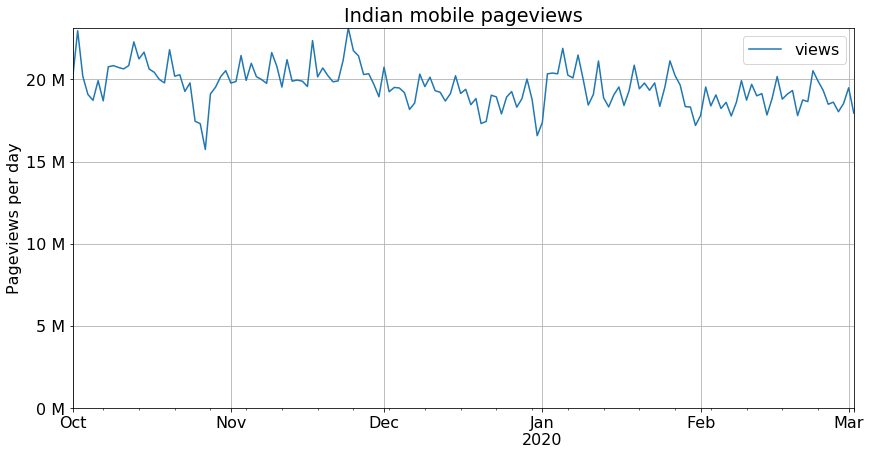

In [83]:
ax = views.plot(ylim=0)
plt.xlabel(None)
plt.ylabel("Pageviews per day")
ax.yaxis.set_major_formatter(M_fmt)
plt.title("Indian mobile pageviews");

In [ ]:
isp_views.to_csv("data/isp-views.csv")

In [ ]:
dates = pd.date_range("2019-11-20", "2019-12-15")
isp_views_fragments = []

for date in dates:
  fragment = wmf.hive.run("""
    SELECT
      isp_data["isp"] AS isp,
      CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
      COUNT(1) AS views
    FROM wmf.webrequest
    WHERE
      geocoded_data["country_code"] = "IN" AND
      isp_data["isp"] IN (
        'Jio', 'Bharti Airtel', 'Vodafone India',
        'Facebook', 'Idea Cellular', 'BSNL',
        'ACT Fibernet', 'Airtel Broadband', 'Hathway',
        'Gtpl Kcbpl Broadband Pvt', 'Hireach Broadband Private', 'Tikona Infinet',
        'Excitel'
      ) AND
      is_pageview AND
      year = 2019 AND
      month = {month} AND
      day = {day}
    GROUP BY
      isp_data["isp"],
      CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
    """.format(month=date.month, day=date.day),
    spark_config=SPARK_CONFIG
  )
  
  isp_views_fragments.append(fragment)

In [ ]:
isp_views = (
  pd
  .concat(isp_views_fragments)
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date > '2019-11-22'") # Remove partial day
  .pivot(index="date", columns="isp")
  .xs("views", axis="columns")
)

In [7]:
isp_views = pd.read_csv("data/isp-views.csv", index_col="date", parse_dates=["date"])

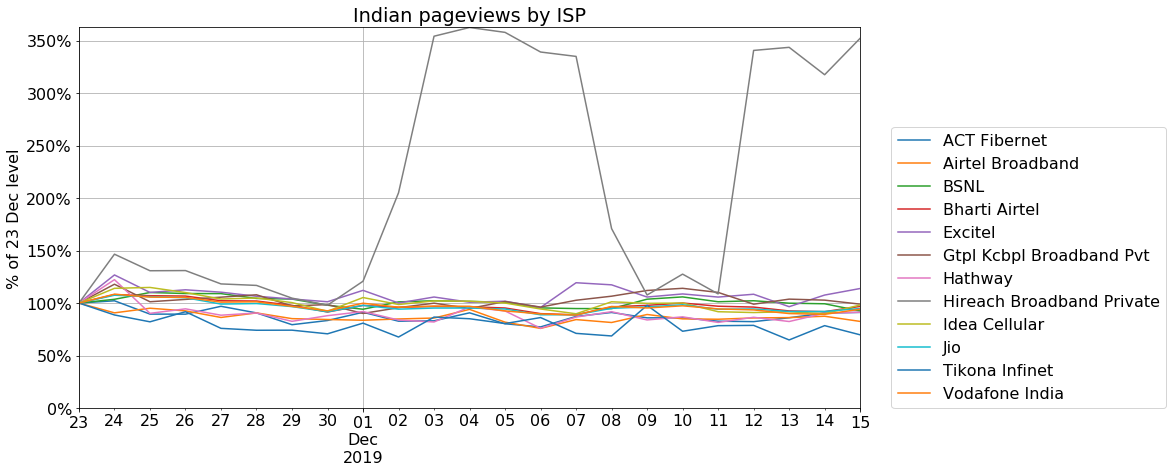

In [10]:
ax = (isp_views / isp_views.loc["2019-11-23"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 23 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian pageviews by ISP");

Counts from 23 November:

In [85]:
isp_views.loc["2019-11-23"].sort_values(ascending=False)

Jio                          9860870
Bharti Airtel                5124888
Vodafone India               1882727
Idea Cellular                1241280
BSNL                          965498
ACT Fibernet                  943964
Airtel Broadband              813691
Hathway                       436801
Excitel                       139122
Tikona Infinet                 88967
Hireach Broadband Private      15560
Gtpl Kcbpl Broadband Pvt        6312
Name: 2019-11-23 00:00:00, dtype: int64

In [86]:
referrer_views = wmf.spark.run("""
SELECT
  referer_class,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.projectview_hourly
WHERE
  country_code = "IN" AND
  access_method = "mobile web" AND
  agent_type != "spider" AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  referer_class,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [87]:
referrer_views = (
  referrer_views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-11'") # Remove partial day
  .pivot(index="date", columns="referer_class")
  .xs("views", axis="columns")
  .fillna(0)
)

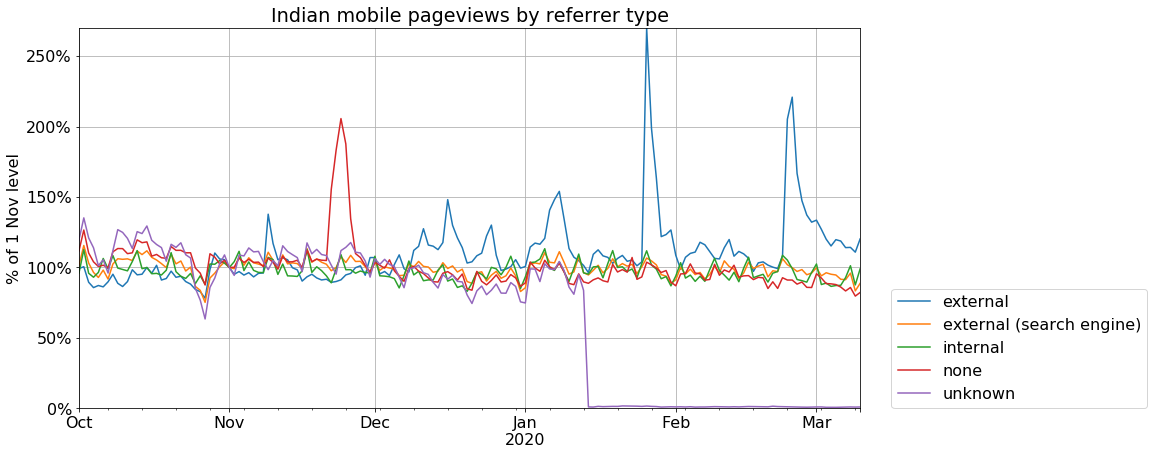

In [88]:
ax = (referrer_views / referrer_views.loc["2019-11-01"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 1 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian mobile pageviews by referrer type");

Counts from 1 November:

In [89]:
referrer_views.loc["2019-11-01"].sort_values(ascending=False)

referer_class
external (search engine)    12214625
internal                     5297076
none                         1797607
unknown                       352649
external                      107576
Name: 2019-11-01 00:00:00, dtype: int64

In [23]:
os_views = wmf.spark.run("""
SELECT
  user_agent_map.os_family as operating_system,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.pageview_hourly
WHERE
  country_code = "IN" AND
  access_method = "mobile web" AND
  agent_type != "spider" AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  user_agent_map.os_family,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [25]:
os_views = (
  os_views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-11'") # Remove partial day
  .pivot(index="date", columns="operating_system")
  .xs("views", axis="columns")
  .fillna(0)
)

In [ ]:
top_oses = (
  os_views
  .sum()
  .sort_values(ascending=False)
  [lambda x: x > 10000000]
  .index
  .to_list()
)

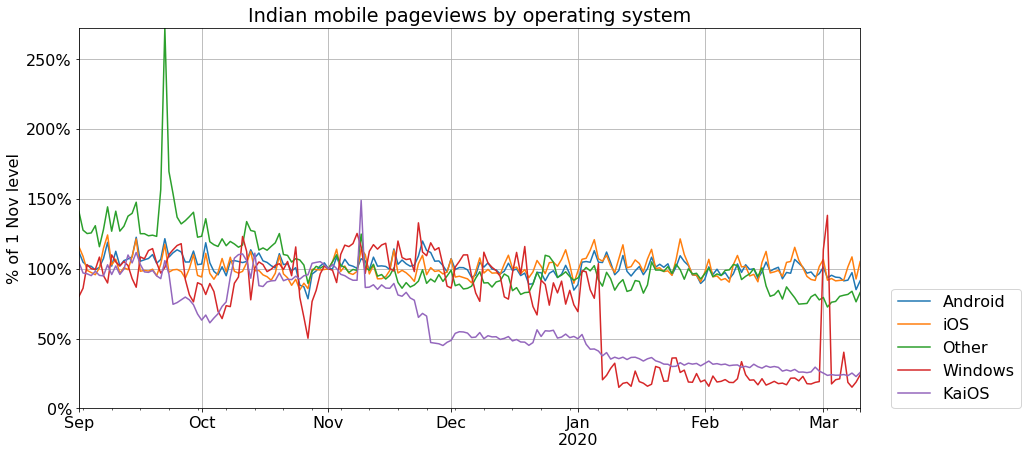

In [36]:
top_os_views = os_views[top_oses]
# Combine Firefox OS and KaiOS
combined = top_os_views["Firefox OS"] + top_os_views["KaiOS"]
top_os_views = top_os_views.drop(["Firefox OS", "KaiOS"], axis=1)
top_os_views["KaiOS"] = combined

ax = (top_os_views / top_os_views.loc["2019-11-01"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 1 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian mobile pageviews by operating system");

Counts from 1 November:

In [92]:
top_os_views.loc["2019-11-01"].sort_values(ascending=False).astype(int)

operating_system
Android    17337501
iOS         1438209
KaiOS        735976
Other         92291
Windows       81334
Name: 2019-11-01 00:00:00, dtype: int64

In [47]:
state_views = wmf.spark.run("""
SELECT
  subdivision AS state,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.pageview_hourly
WHERE
  country_code = "IN" AND
  access_method = "mobile web" AND
  agent_type != "spider" AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  subdivision,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [48]:
state_views = (
  state_views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-11'") # Remove partial day
  .pivot(index="date", columns="state")
  .xs("views", axis="columns")
  .fillna(0)
)

In [52]:
top_states = (
  state_views
  .sum()
  .sort_values(ascending=False)
  [lambda x: x > 20000000]
  .index
  .to_list()
)

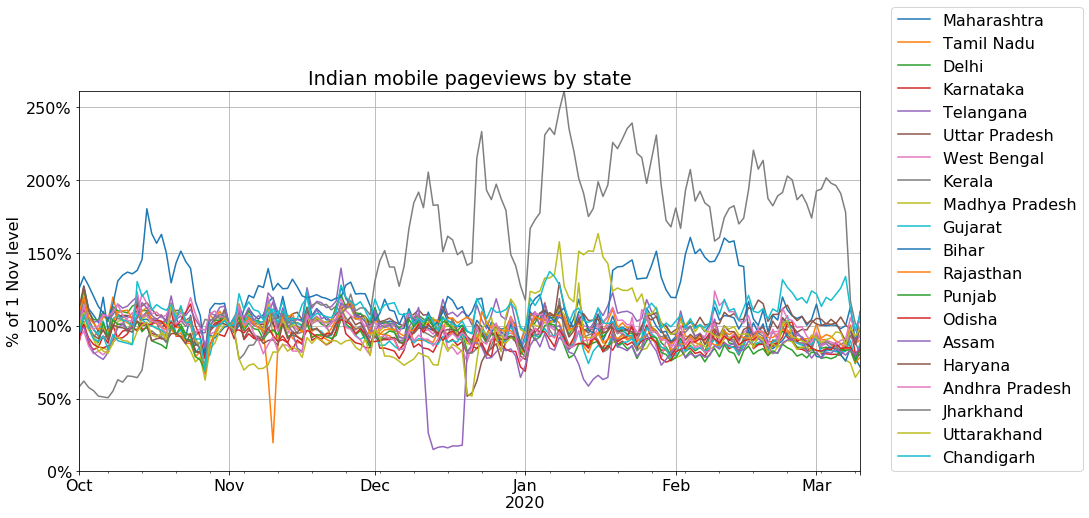

In [54]:
top_state_views = state_views[top_states]
top_state_views = top_state_views.rename({"National Capital Territory of Delhi": "Delhi"}, axis=1)
ax = (top_state_views / top_state_views.loc["2019-11-01"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 1 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian mobile pageviews by state");

Counts from 1 November:

In [94]:
top_state_views.loc["2019-11-01"].sort_values(ascending=False).astype(int)

state
Maharashtra       2883443
Karnataka         2038884
Tamil Nadu        2033687
Delhi             1957799
Telangana         1379016
Uttar Pradesh     1340806
West Bengal       1221746
Kerala            1087229
Madhya Pradesh     950998
Gujarat            844165
Rajasthan          691024
Bihar              646692
Punjab             421183
Assam              410658
Odisha             402504
Haryana            294980
Andhra Pradesh     208946
Uttarakhand        163224
Jharkhand          130491
Chandigarh         120549
Name: 2019-11-01 00:00:00, dtype: int64

# KaiOS specific trends

In [57]:
kaios_state_views = wmf.spark.run("""
SELECT
  subdivision AS state,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.pageview_hourly
WHERE
  country_code = "IN" AND
  user_agent_map["os_family"] IN ("Firefox OS", "KaiOS") AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  subdivision,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [58]:
kaios_state_views = (
  kaios_state_views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-11'") # Remove partial day
  .pivot(index="date", columns="state")
  .xs("views", axis="columns")
  .fillna(0)
)

In [95]:
kaios_top_states = (
  kaios_state_views
  .sum()
  .sort_values(ascending=False)
  [lambda x: x > 500000]
  .index
  .to_list()
)

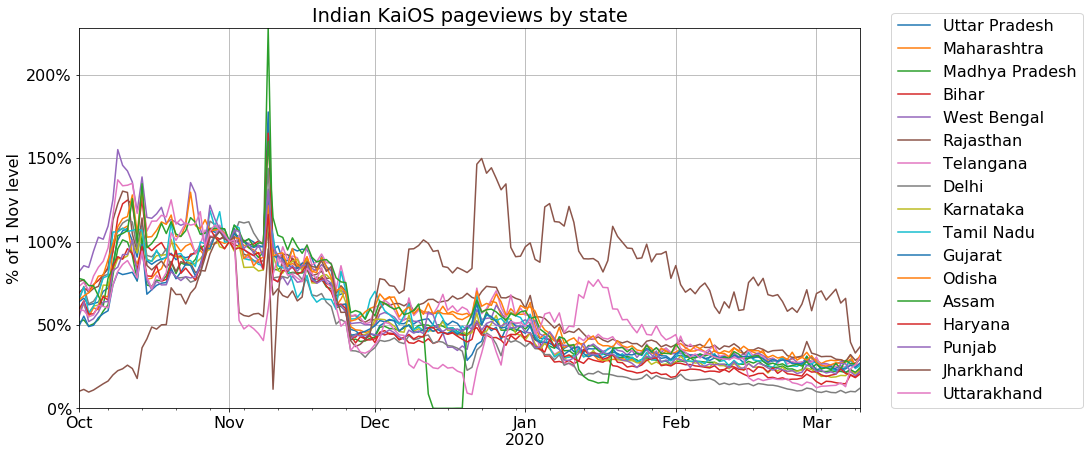

In [96]:
kaios_top_state_views = kaios_state_views[kaios_top_states]
kaios_top_state_views = kaios_top_state_views.rename({"National Capital Territory of Delhi": "Delhi"}, axis=1)

ax = (kaios_top_state_views / kaios_top_state_views.loc["2019-11-01"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 1 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian KaiOS pageviews by state");

Counts from 1 November:

In [97]:
top_state_views.loc["2019-11-01"].sort_values(ascending=False).astype(int)

state
Maharashtra       2883443
Karnataka         2038884
Tamil Nadu        2033687
Delhi             1957799
Telangana         1379016
Uttar Pradesh     1340806
West Bengal       1221746
Kerala            1087229
Madhya Pradesh     950998
Gujarat            844165
Rajasthan          691024
Bihar              646692
Punjab             421183
Assam              410658
Odisha             402504
Haryana            294980
Andhra Pradesh     208946
Uttarakhand        163224
Jharkhand          130491
Chandigarh         120549
Name: 2019-11-01 00:00:00, dtype: int64

In [62]:
kaios_referrer_views = wmf.spark.run("""
SELECT
  referer_class,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0")) AS date,
  SUM(view_count) AS views
FROM wmf.pageview_hourly
WHERE
  country_code = "IN" AND
  user_agent_map["os_family"] IN ("Firefox OS", "KaiOS") AND
  (
    year = 2019 AND month >= 10 OR
    year = 2020
   )
GROUP BY
  referer_class,
  CONCAT_WS("-", year, LPAD(month, 2, "0"), LPAD(day, 2, "0"))
""", session_type="large")

In [63]:
kaios_referrer_views = (
  kaios_referrer_views
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .query("date < '2020-03-11'") # Remove partial day
  .pivot(index="date", columns="referer_class")
  .xs("views", axis="columns")
  .fillna(0)
)

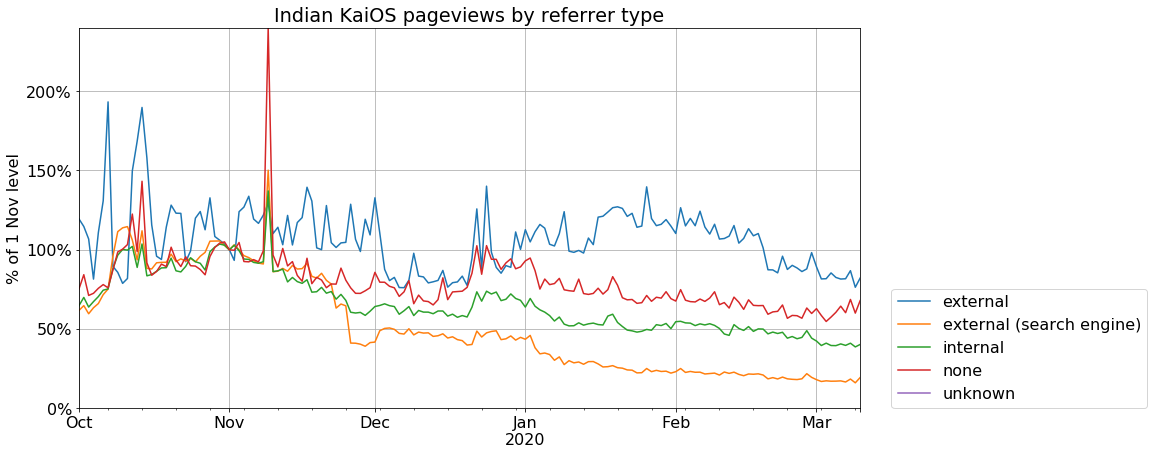

In [73]:
ax = (kaios_referrer_views / kaios_referrer_views.loc["2019-11-01"]).plot(ylim=0)
plt.legend(loc=[1.04, 0])
plt.ylabel("% of 1 Nov level")
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel(None)
plt.title("Indian KaiOS pageviews by referrer type");

Counts from 1 November:

In [98]:
kaios_referrer_views.loc["2019-11-01"].sort_values(ascending=False).astype(int)

referer_class
external (search engine)    542355
internal                    178307
none                         15840
external                      6047
unknown                          0
Name: 2019-11-01 00:00:00, dtype: int64

In [65]:
kaios_internal_views = kaios_referrer_views["internal"]
kaios_external_views = kaios_referrer_views.drop(["unknown", "internal"], axis=1)

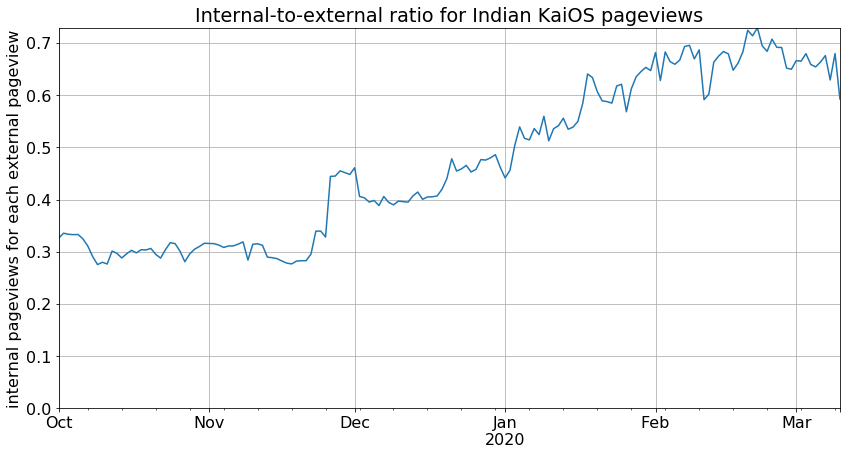

In [72]:
ax = (kaios_internal_views / kaios_external_views.sum(axis=1)).plot(ylim=0)
plt.xlabel(None)
plt.ylabel("internal pageviews for each external pageview")
plt.title("Internal-to-external ratio for Indian KaiOS pageviews");